In [1]:
# Standard library imports
from io import BytesIO
from pprint import pprint

# Third-party imports
import numpy as np
import pandas as pd
import requests
import torch
from PIL import Image
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import train_test_split
import mlflow
from mlflow import MlflowClient
from torch import nn
from torchmetrics import Accuracy
from torchinfo import summary
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Notes

- Alternative approach to loading data could be to download a sample of images locally start and train on those. When ready to train on all images, load them all and train. 

- Dataset cleaning
  - remove urls that don't load
  - remove classes with less than 10 images

- Preprocess: 
  - set to 224, 224, 3
  - standardize by dividing by 255

In [2]:
latin_to_common_name_map = {
    "Adalia bipunctata": "Two-spot ladybird",
    "Adalia decempunctata": "Ten-spot ladybird",
    "Anatis ocellata": "Eyed ladybird",
    "Anisosticta novemdecimpunctata": "Water ladybird",
    "Aphidecta obliterata": "Larch ladybird",
    "Brumus quadripustulatus": "Four-spot ladybird",
    "Calvia quatuordecimguttata": "Cream-spot ladybird",
    "Chilocorus bipustulatus": "Mediterranean ladybird",
    "Chilocorus renipustulatus": "Kidney-spot ladybird",
    "Coccidula rufa": "Red marsh ladybird",
    "Coccidula scutellata": "Heathland ladybird",
    "Coccinella hieroglyphica": "Hieroglyphic ladybird",
    "Coccinella magnifica": "Scarce seven-spot ladybird",
    "Coccinella quinquepunctata": "Five-spot ladybird",
    "Coccinella septempunctata": "Seven-spot ladybird",
    "Coccinella undecimpunctata": "Eleven-spot ladybird",
    "Cryptolaemus montrouzieri": "Mealybug destroyer",
    "Halyzia sedecimguttata": "Orange ladybird",
    "Harmonia axyridis": "Harlequin ladybird",
    "Harmonia quadripunctata": "Pine ladybird",
    "Henosepilachna argus": "Bryony ladybird",
    "Hippodamia variegata": "Adonis ladybird",
    "Myrrha octodecimguttata": "Eighteen-spot ladybird",
    "Myzia oblongoguttata": "Striped ladybird",
    "Nephus quadrimaculatus": "Four-spotted Scymnus",
    "Nephus redtenbacheri": "Small Scymnus",
    "Propylaea quatuordecimpunctata": "Fourteen-spot ladybird",
    "Psyllobora vigintiduopunctata": "Twenty-two-spot ladybird",
    "Rhyzobius chrysomeloides": "No common name",
    "Rhyzobius forestieri": "No common name",
    "Rhyzobius litura": "No common name",
    "Rhyzobius lophanthae": "No common name",
    "Scymnus auritus": "Hairy Scymnus",
    "Scymnus interruptus": "Interrupted Scymnus",
    "Scymnus suturalis": "Sutural Scymnus",
    "Stethorus pusillus": "Tiny Stethorus",
    "Subcoccinella vigintiquatuorpunctata": "24-spot ladybird",
    "Tytthaspis sedecimpunctata": "Sixteen-spot ladybird"
}

In [3]:
full_df = pd.read_csv('ladybird_full.csv')
label_to_species_map = dict(zip(full_df['label'].unique(), full_df['species'].unique()))

In [4]:
sorted(label_to_species_map.items(), key=lambda x: x[0])

[(0, 'Adalia bipunctata'),
 (1, 'Adalia decempunctata'),
 (2, 'Anatis ocellata'),
 (3, 'Anisosticta novemdecimpunctata'),
 (4, 'Aphidecta obliterata'),
 (5, 'Brumus quadripustulatus'),
 (6, 'Calvia quatuordecimguttata'),
 (7, 'Chilocorus bipustulatus'),
 (8, 'Chilocorus renipustulatus'),
 (9, 'Coccidula rufa'),
 (10, 'Coccidula scutellata'),
 (11, 'Coccinella hieroglyphica'),
 (12, 'Coccinella magnifica'),
 (13, 'Coccinella quinquepunctata'),
 (14, 'Coccinella septempunctata'),
 (15, 'Coccinella undecimpunctata'),
 (16, 'Cryptolaemus montrouzieri'),
 (17, 'Halyzia sedecimguttata'),
 (18, 'Harmonia axyridis'),
 (19, 'Harmonia quadripunctata'),
 (20, 'Henosepilachna argus'),
 (21, 'Hippodamia variegata'),
 (22, 'Myrrha octodecimguttata'),
 (23, 'Myzia oblongoguttata'),
 (24, 'Nephus quadrimaculatus'),
 (25, 'Nephus redtenbacheri'),
 (26, 'Propylaea quatuordecimpunctata'),
 (27, 'Psyllobora vigintiduopunctata'),
 (28, 'Rhyzobius chrysomeloides'),
 (29, 'Rhyzobius forestieri'),
 (30, 'Rhyz

# Load data

In [5]:
small = True

In [6]:
if small == True:
    train_df = pd.read_pickle('ladybird_train_small_preprocessed.pkl')
    test_df = pd.read_pickle('ladybird_test_small_preprocessed.pkl')
else:
    train_df = pd.read_pickle('ladybird_train_preprocessed.pkl')
    test_df = pd.read_pickle('ladybird_test_preprocessed.pkl')

In [7]:
# Some images are missing, so we need to remove them from the dataframe
print(train_df.isnull().sum())
print(test_df.isnull().sum())

scientificName    0
species           0
url               0
label             0
image_array       9
dtype: int64
scientificName    0
species           0
url               0
label             0
image_array       1
dtype: int64


In [8]:
train_df = train_df.dropna()
test_df = test_df.dropna()

In [9]:
train_images = np.array([i for i in train_df['image_array']])
train_labels = train_df['label']

test_images = np.array([i for i in test_df['image_array']])
test_labels = test_df['label']

In [45]:
train_images[0]

tensor([[[0.6863, 0.6784, 0.6588,  ..., 0.7412, 0.7412, 0.7333],
         [0.6627, 0.6549, 0.6314,  ..., 0.7373, 0.7294, 0.7333],
         [0.6549, 0.6314, 0.6078,  ..., 0.7176, 0.7137, 0.7098],
         ...,
         [0.5529, 0.5725, 0.5569,  ..., 0.4627, 0.4392, 0.4157],
         [0.5686, 0.5725, 0.5843,  ..., 0.4157, 0.3961, 0.3765],
         [0.6118, 0.5725, 0.5804,  ..., 0.3882, 0.3725, 0.3529]],

        [[0.5176, 0.5098, 0.4941,  ..., 0.8392, 0.8353, 0.8196],
         [0.4941, 0.4941, 0.4863,  ..., 0.8235, 0.8157, 0.8157],
         [0.4902, 0.4824, 0.4902,  ..., 0.7961, 0.7961, 0.7922],
         ...,
         [0.5961, 0.6118, 0.6000,  ..., 0.3686, 0.3451, 0.3294],
         [0.6078, 0.6157, 0.6275,  ..., 0.3216, 0.3098, 0.2941],
         [0.6510, 0.6157, 0.6235,  ..., 0.2941, 0.2863, 0.2745]],

        [[0.4471, 0.4353, 0.4275,  ..., 0.3451, 0.3490, 0.3569],
         [0.4196, 0.4157, 0.4078,  ..., 0.3412, 0.3373, 0.3490],
         [0.4118, 0.4039, 0.3922,  ..., 0.3333, 0.3294, 0.

In [10]:
print(f'Size of training set: {len(train_images)}')
print(f'Size of test set: {len(test_images)}')

Size of training set: 6862
Size of test set: 1717


Label: 14
Species: Coccinella septempunctata


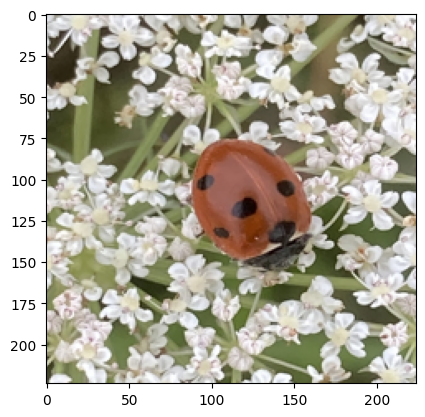

In [11]:
plt.imshow(train_images[0])
print(f'Label: {train_labels[0]}')
print(f'Species: {label_to_species_map[train_labels[0]]}')

# Model architecture

In [12]:
# Assuming your images are in a numpy array 'images' of shape (num_samples, 224, 224, 3)
# and labels in a numpy array 'labels' (num_samples,)
# Make sure that both are numpy arrays.

batch_size = 32

# Convert data to PyTorch tensors
images = torch.tensor(train_images, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to (num_samples, 3, 224, 224)
labels = torch.tensor(train_labels, dtype=torch.long)

# Define train-validation split (80-20 split)
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create PyTorch datasets and loaders
train_dataset = TensorDataset(train_images, train_labels)
val_dataset = TensorDataset(val_images, val_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [13]:
for X, y in train_loader:
    print(f"Shape of train X [N, C, H, W]: {X.shape}")
    print(f"Shape of train y: {y.shape} {y.dtype}")
    break

for X, y in val_loader:
    print(f"Shape of val X [N, C, H, W]: {X.shape}")
    print(f"Shape of val y: {y.shape} {y.dtype}")
    break

Shape of train X [N, C, H, W]: torch.Size([32, 3, 224, 224])
Shape of train y: torch.Size([32]) torch.int64
Shape of val X [N, C, H, W]: torch.Size([32, 3, 224, 224])
Shape of val y: torch.Size([32]) torch.int64


Each CNN layer modifies spatial dimensions according to the formula

- Output Size= (Input Size - Kernel Size + 2.Padding / Stride) + 1

Pooling layers reduce spatial dimensions by dividing the input size by the pooling kernel size and stride (e.g. if kernel size and stride = 2, it halves the size)

For a pooling kernel of 𝐻pool×𝑊pool and stride 𝑆height × 𝑆width:


- Output Height = ((Input Height − 𝐻pool) / 𝑆height) + 1
- Output Width = ((Input wIDTH − Wpool) / 𝑆width) + 1
​

In [33]:

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define a basic neural network model

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=128 * 28 * 28, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.relu = nn.ReLU()

    def forward(self, x):
            x = self.pool(self.relu(self.conv1(x))) # batch_size * 112 * 112 * 32
            x = self.pool(self.relu(self.conv2(x))) # batch_size * 56 * 56 * 64
            x = self.pool(self.relu(self.conv3(x))) # batch_size * 28 * 28 * 128
            x = x.view(-1, 128 * 28 * 28)  # Flatten for fully connected layer. # 28 * 28 since we have 3 maxpool layers with pool size 2 and stride 2 -> 224 / 2 / 2 / 2 = 28 # could use nn.Flatten() instead
            x = self.relu(self.fc1(x)) # batch_size * 512
            x = self.fc2(x) # batch_size * num_classes
            return x

Using mps device


In [34]:
# Function to select optimizer
def get_optimizer(optimizer_name, model, lr=0.01):
    if optimizer_name == 'SGD':
        return optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == 'Adam':
        return optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSprop':
        return optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")


In [35]:
# def train(dataloader, model, loss_fn, optimizer, metric_fn, epoch):
#     model.train()

#     for batch, (X, y) in enumerate(dataloader):
#         X, y = X.to(device), y.to(device)

#         pred = model(X)
#         loss = loss_fn(pred, y)
#         accuracy = metric_fn(pred, y)

#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()


#         # Log metrics every `log_every` batches
#         if batch % 25 == 0:
#             # Calculate batch-level metrics
#             loss, current = loss.item(), batch

#             step = batch // 25 * (epoch + 1)

#             # Log metrics to MLflow for the current batch
#             mlflow.log_metric('train_loss', loss, step=step)
#             mlflow.log_metric('train_accuracy', accuracy, step=step)

#             print(f"loss: {loss:2f} accuracy: {accuracy:2f} [{current} / {len(train_loader)}]")

In [36]:
def train(dataloader, model, loss_fn, optimizer, metric_fn, epoch):
    model.train()

    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        accuracy = metric_fn(pred, y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        total_accuracy += accuracy.item()

    # Calculate average loss and accuracy for the epoch
    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches

    # Log metrics to MLflow at the end of each epoch
    mlflow.log_metric('train_loss', avg_loss, step=epoch)
    mlflow.log_metric('train_accuracy', avg_accuracy, step=epoch)

    print(f"Epoch {epoch + 1} - Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.2f}")

In [37]:
# Evaluation function
def evaluate(dataloader, model, loss_fn, metrics_fn, epoch):

    num_batches = len(dataloader)
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            eval_loss += loss_fn(pred, y).item()
            eval_accuracy += metrics_fn(pred, y)

    eval_loss /= num_batches
    eval_accuracy /= num_batches
    mlflow.log_metric("eval_loss", f"{eval_loss:2f}", step=epoch)
    mlflow.log_metric("eval_accuracy", f"{eval_accuracy:2f}", step=epoch)

    print(f"Eval metrics: \nAccuracy: {eval_accuracy:.2f}, Avg loss: {eval_loss:2f} \n")

In [38]:
client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

In [39]:

# Provide an Experiment description that will appear in the UI
experiment_description = (
    "This is a ladybird classification project. "
    "This experiment trains on the small dataset with no transfer learning."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "ladybird-classification-small",
    "dataset": "small",
    "transfer_learning": "false",
    "mlflow.note.content": experiment_description,
}

# # Create the Experiment, providing a unique name
# ladybird_small_experiment = client.create_experiment(
#     name="ladybird_small", tags=experiment_tags
# )


In [40]:
# # Start up server
# mlflow server --host 127.0.0.1 --port 8080

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment(experiment_name="ladybird_small")

<Experiment: artifact_location='mlflow-artifacts:/407241657968160047', creation_time=1732125832891, experiment_id='407241657968160047', last_update_time=1732125832891, lifecycle_stage='active', name='ladybird_small', tags={}>

In [41]:
epochs = 15

loss_fn = nn.CrossEntropyLoss()

num_classes = len(label_to_species_map)  # Unique classes

metric_fn = Accuracy(task="multiclass", num_classes=num_classes).to(device)

model = SimpleCNN(num_classes=num_classes).to(device)

optimizer_name = 'Adam'  # Choose 'SGD', 'Adam', or 'RMSprop'
learning_rate = 0.001
optimizer = get_optimizer(optimizer_name, model, lr=learning_rate)

print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=38, bias=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


In [42]:
with mlflow.start_run() as run:
    params = {
        "epochs": epochs,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "loss_function": loss_fn.__class__.__name__,
        "metric_function": metric_fn.__class__.__name__,
        "optimizer": optimizer_name,
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_loader, model, loss_fn, optimizer, metric_fn, epoch=t)
        evaluate(val_loader, model, loss_fn, metric_fn, epoch=t)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model")

Epoch 1
-------------------------------
Epoch 1 - Average Loss: 2.0530, Average Accuracy: 0.37
Eval metrics: 
Accuracy: 0.40, Avg loss: 1.952921 

Epoch 2
-------------------------------
Epoch 2 - Average Loss: 1.9245, Average Accuracy: 0.41
Eval metrics: 
Accuracy: 0.41, Avg loss: 1.866248 

Epoch 3
-------------------------------
Epoch 3 - Average Loss: 1.8017, Average Accuracy: 0.45
Eval metrics: 
Accuracy: 0.46, Avg loss: 1.737037 

Epoch 4
-------------------------------
Epoch 4 - Average Loss: 1.5980, Average Accuracy: 0.50
Eval metrics: 
Accuracy: 0.45, Avg loss: 1.767083 

Epoch 5
-------------------------------
Epoch 5 - Average Loss: 1.3666, Average Accuracy: 0.57
Eval metrics: 
Accuracy: 0.50, Avg loss: 1.745021 

Epoch 6
-------------------------------
Epoch 6 - Average Loss: 0.9846, Average Accuracy: 0.68
Eval metrics: 
Accuracy: 0.48, Avg loss: 2.052147 

Epoch 7
-------------------------------
Epoch 7 - Average Loss: 0.5752, Average Accuracy: 0.81
Eval metrics: 
Accuracy

In [43]:
# Exploring the model

/Users/kaimajerus/.pyenv/versions/3.10.6/envs/data-science-portfolio/lib/python3.10/site-packages/torch/_tensor_str.py:145: UserWarning: MPS: nonzero op is supported natively starting from macOS 14.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:361.)
  nonzero_finite_vals = torch.masked_select(


logits: tensor([[ 9.7589e+00, -8.7844e+00,  1.4130e-01,  ..., -3.4481e+01,
         -1.8400e+01, -3.0109e+01],
        [ 4.9745e+00, -2.8241e+00, -8.2062e+00,  ..., -2.0060e+01,
         -1.4583e+01, -4.0790e+00],
        [ 7.0597e+00, -5.0791e+00, -6.9742e+00,  ..., -2.3972e+01,
         -1.0943e+01, -1.6343e+01],
        ...,
        [ 1.7176e+01,  1.5307e+01,  1.6863e+01,  ..., -3.1861e+01,
         -1.9283e+01, -2.9332e+01],
        [ 1.5330e+01,  3.3159e-02, -9.4479e+00,  ..., -3.5557e+01,
         -3.5700e+00, -3.2906e+01],
        [-1.0368e+00, -5.8606e+00, -1.1818e+00,  ..., -3.5701e+01,
         -1.0865e+01, -5.1357e+00]], device='mps:0')
probs: tensor([[6.1521e-08, 5.4423e-16, 4.0942e-12,  ..., 3.7675e-27, 3.6288e-20,
         2.9833e-25],
        [2.2703e-03, 9.3147e-07, 4.2830e-09,  ..., 3.0445e-14, 7.2853e-12,
         2.6559e-07],
        [2.1630e-03, 1.1567e-08, 1.7388e-09,  ..., 7.2154e-17, 3.2839e-11,
         1.4838e-13],
        ...,
        [5.6854e-05, 8.7757e-06, 

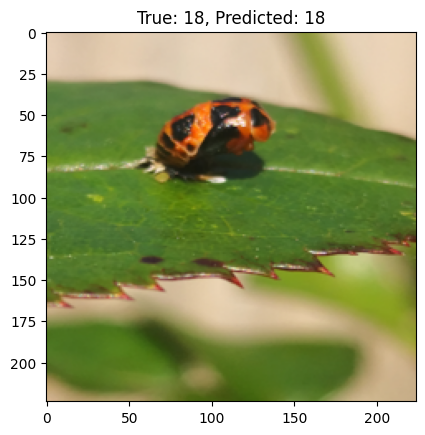

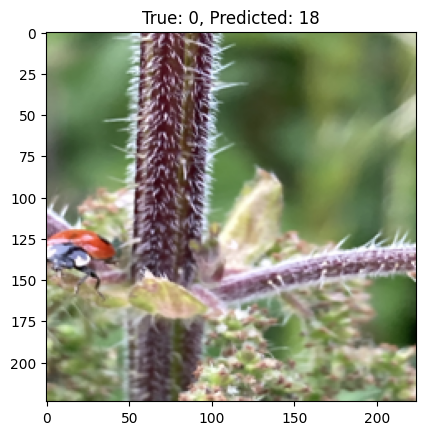

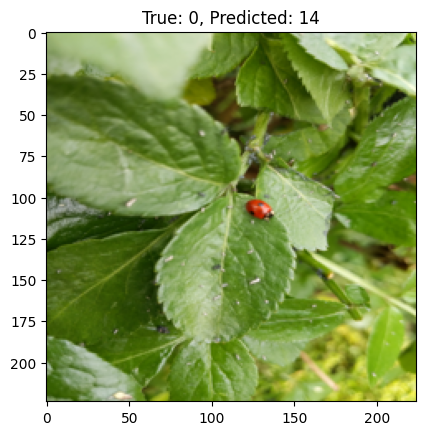

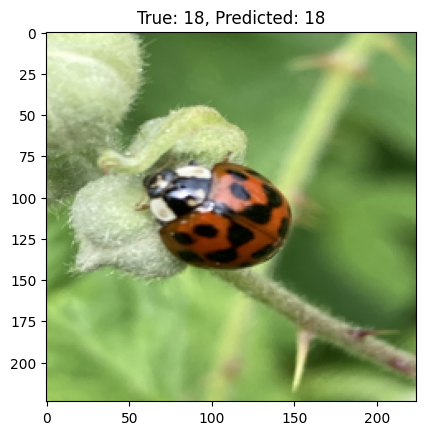

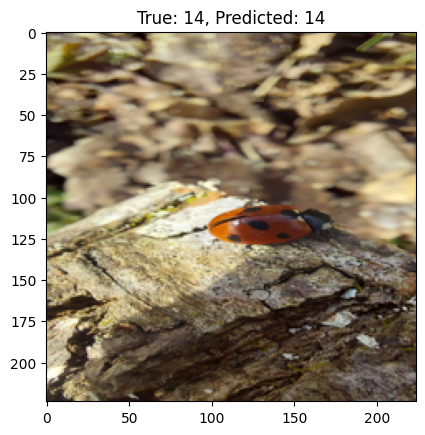

In [44]:
# use the model to make a prediction on a random image from the train set and then plot the image and print the prediction
model.eval()
with torch.no_grad():
    X, y = next(iter(val_loader))
    X, y = X.to(device), y.to(device)
    logits = model(X)
    print(f'logits: {logits}')
    probabilities = torch.softmax(logits, dim=1)
    print(f'probs: {probabilities}')
    pred = torch.argmax(probabilities, dim=1)
    print(f'preds: {pred}')
    print(f'Actual: {y}')

    for i in range(5):
        plt.imshow(X[i].permute(1, 2, 0).cpu())
        plt.title(f"True: {y[i].item()}, Predicted: {pred[i].item()}")
        plt.show()

logits: tensor([[ -7.9504,  -1.4344,  -4.4484,  ..., -13.3422, -27.8013, -21.0001],
        [  2.7368,  -0.4074,  -2.7107,  ..., -13.8496,  -7.5496,  -4.5976],
        [  1.1464,  -2.5544,  -5.4336,  ..., -15.2045,  -9.9054, -13.1673],
        ...,
        [  9.1682,   7.3799,  11.0270,  ..., -30.9966, -27.3046, -15.9554],
        [  6.7042,   5.4102, -13.0875,  ..., -33.8267, -15.5759, -21.2902],
        [ 14.4368,  -7.3535,   0.5441,  ..., -39.5027,  11.5839,   1.4868]],
       device='mps:0')
probs: tensor([[2.1057e-15, 1.4231e-12, 6.9869e-14,  ..., 9.5880e-18, 5.0379e-24,
         4.5284e-21],
        [4.4043e-05, 1.8984e-06, 1.8970e-07,  ..., 2.7574e-12, 1.5016e-09,
         2.8747e-08],
        [8.7625e-08, 2.1647e-09, 1.2162e-10,  ..., 6.9427e-15, 1.3896e-12,
         5.3246e-14],
        ...,
        [2.3601e-11, 3.9470e-12, 1.5143e-10,  ..., 8.5032e-29, 3.4118e-27,
         2.8966e-22],
        [2.5596e-06, 7.0183e-07, 6.4980e-15,  ..., 6.3949e-24, 5.3957e-16,
         1.7798e

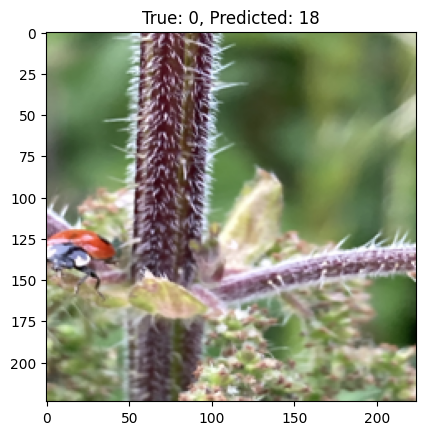

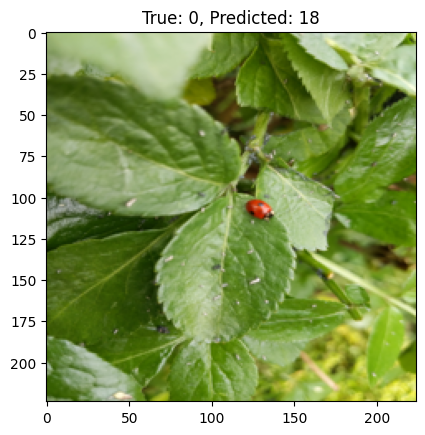

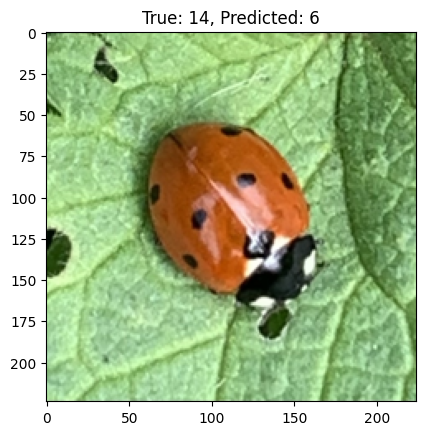

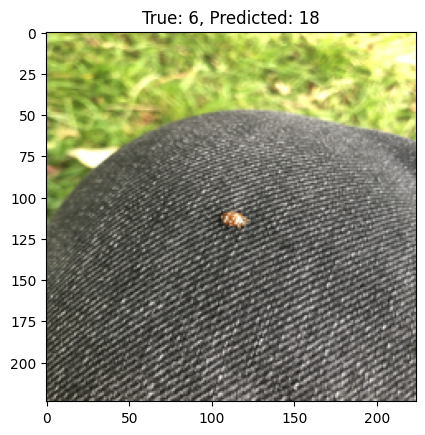

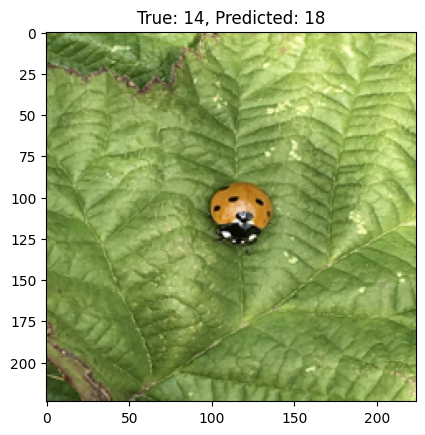

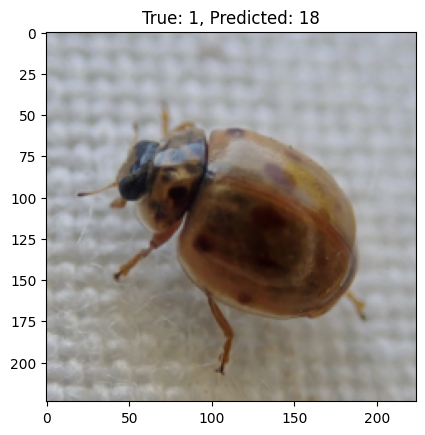

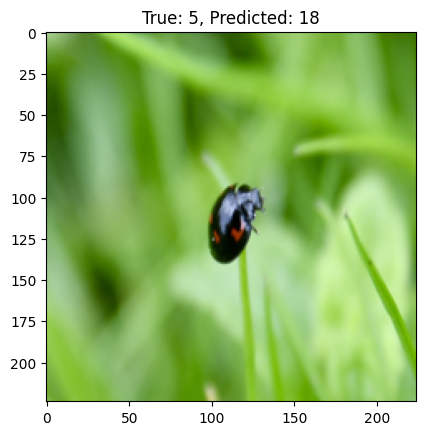

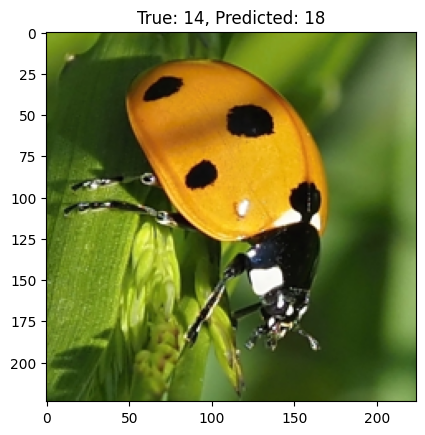

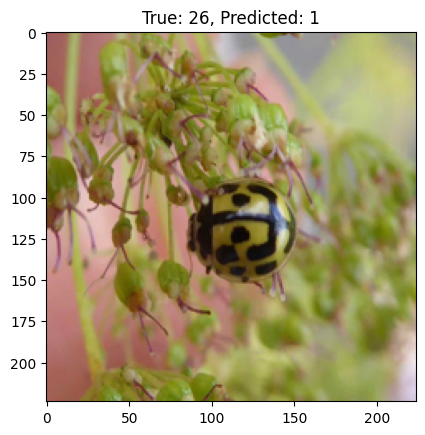

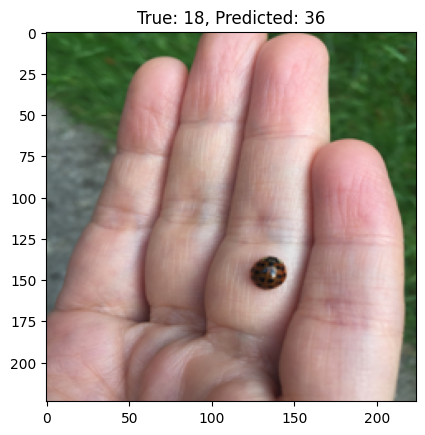

In [ ]:
# Find incorrect predictions
model.eval()
with torch.no_grad():
    incorrect = []
    for X, y in val_loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        print(f'logits: {logits}')
        probabilities = torch.softmax(logits, dim=1)
        print(f'probs: {probabilities}')
        pred = torch.argmax(probabilities, dim=1)
        print(f'preds: {pred}')
        print(f'Actual: {y}')

        for i in range(len(y)):
            if pred[i] != y[i]:
                incorrect.append((X[i], y[i], pred[i]))


for i in range(10):
    plt.imshow(incorrect[i][0].permute(1, 2, 0).cpu())
    plt.title(f"True: {incorrect[i][1].item()}, Predicted: {incorrect[i][2].item()}")
    plt.show()

Benefits of Dropout:
Reduces overfitting: By making the network less reliant on specific neurons and forcing it to learn more generalized features.
Improves robustness: The model learns to perform well even when some parts of it are missing, making it more resilient to noise or missing information in real-world data.
Simpler than traditional regularization methods: Unlike L2 or L1 regularization, dropout doesn’t penalize weights directly but introduces stochasticity that leads to better regularization in practice.

Example:
Suppose a dropout rate of 0.5 is used in a layer. This means that during each training iteration, 50% of the neurons in that layer are randomly ignored. However, during inference (when making predictions), all the neurons are used, and their outputs are scaled down by 50% to maintain the same overall expected output.

Pro Tips 💡
**[Strongly recommended]**

- Start your model from the last layer
- Implement the easiest architecture first
- Stick with the same batch size (eg. 32 for large data, more if it fits on RAM). Change it - only once your are confident about its impact.
- Don't think about the number of epochs (set to a high number): it has to hit your early_stopping criterion


***[Apply wisely]***

- Try to make your model overfit before regularizing (it is good to see that your model does learn, even too much!)
- If you can't overfit, try fine-tuning your learning rate (or change the model's architecture)
- If train loss was on a steep decreasing trajectory when hitting early stopping, chances are that regularization will improve performance
- Only then, you can regularize
- Try to regularize the last layers before the first ones